<a href="https://colab.research.google.com/github/MarkStephens060482/Classification/blob/main/MNIST%20Sign%20Language%20CNN%20and%20ResNet%20model%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Sign Language CNN and ResNet Classifier
Mark Stephens

# 1. Load and inspect the data

We will use a dataset that contains images of hands in poses corresponding to letters in Amercian Sign Language. Each image is small (similar to MNIST size) and we will build a CNN classifier (using Keras) to determine the corresponding letter for an image.

1. Load the dataset, look at examples of the images and the summary statistics and information for the class labels.

In [1]:
%%capture
!pip install kaggle
!pip install tensorflow
!pip install visualkeras

In [2]:
# Upload your Kaggle API key file
from google.colab import files
files.upload()
# Move the uploaded API key to the appropriate folder
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

import kaggle
# Download the Sign Language MNIST dataset
!kaggle datasets download -d datamunge/sign-language-mnist

# Unzip the downloaded dataset
!unzip sign-language-mnist.zip

# Load the dataset into a Pandas dataframe
import pandas as pd
train_df = pd.read_csv("sign_mnist_train.csv")
test_df = pd.read_csv("sign_mnist_test.csv")

Saving kaggle.json to kaggle.json
 88% 55.0M/62.6M [00:00<00:00, 141MB/s]
100% 62.6M/62.6M [00:00<00:00, 145MB/s]
Archive:  sign-language-mnist.zip
  inflating: amer_sign2.png          
  inflating: amer_sign3.png          
  inflating: american_sign_language.PNG  
  inflating: sign_mnist_test.csv     
  inflating: sign_mnist_test/sign_mnist_test.csv  
  inflating: sign_mnist_train.csv    
  inflating: sign_mnist_train/sign_mnist_train.csv  


In [3]:
import numpy as np
#define training features and label variables.
#define testing features and label variables.
X_train = train_df.drop('label',axis = 1)
y_train = train_df['label']
X_test = test_df.drop('label',axis = 1)
y_test = test_df['label']
# Identify shape of training and testing data sets
print(f'The instances of training data are {X_train.shape[0]}\
 images with {int(np.sqrt(X_train.shape[1]))} x {int(np.sqrt(X_train.shape[1]))} pixels')
print(f'The instances of testing data are {X_test.shape[0]}\
 images with {int(np.sqrt(X_test.shape[1]))} x {int(np.sqrt(X_test.shape[1]))} pixels')

The instances of training data are 27455 images with 28 x 28 pixels
The instances of testing data are 7172 images with 28 x 28 pixels


Summary statistics and information for class labels.

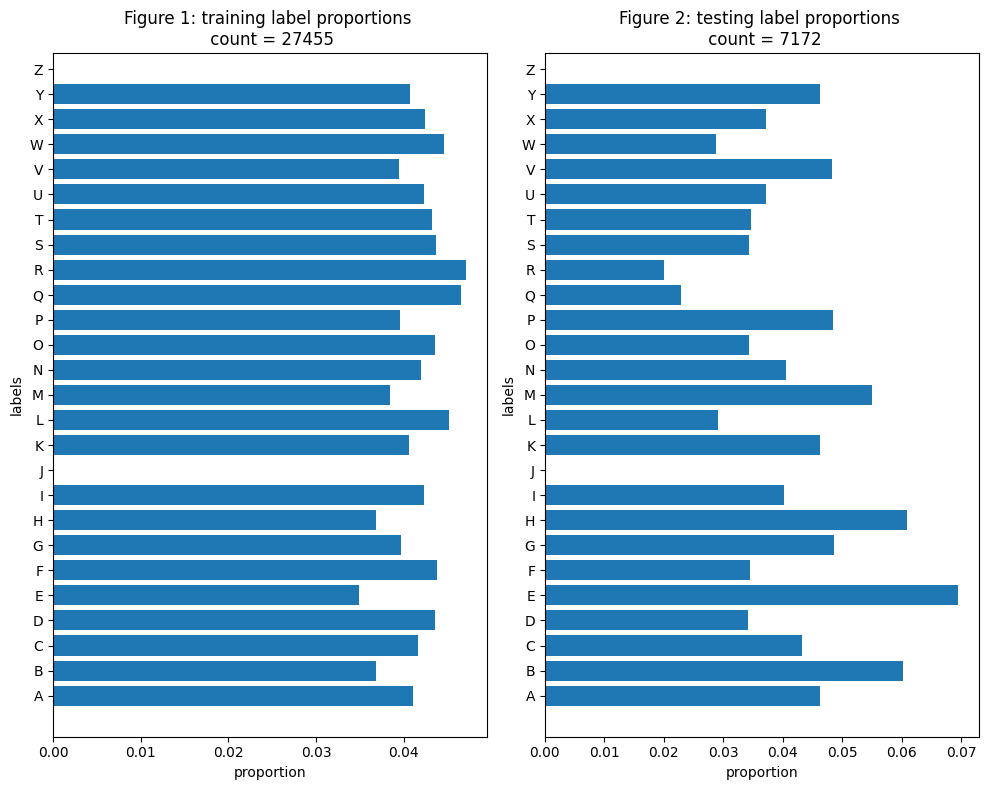

In [4]:
import matplotlib.pyplot as plt
#Define a dictionary to map labels to corresponding ASL alphabets
asl_alphabets = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E',
    5: 'F', 6: 'G', 7: 'H', 8: 'I', 9:'J',
    10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O',
    15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T',
    20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y',
    25: 'Z'
}
# produce proportions of each class in train and test set and display as bar graphs
train_label_count = y_train.count()
test_label_count = y_test.count()
train_label_proportion = y_train.value_counts().sort_index()/train_label_count
test_label_proportion = y_test.value_counts().sort_index()/test_label_count
label_proportions_data = [train_label_proportion,test_label_proportion]
label_counts = [train_label_count,test_label_count]
fig,axs = plt.subplots(1,2,figsize=(10,8))
axs = axs.ravel()
for i,ax in enumerate(axs):
  ax.barh(label_proportions_data[i].index,
         label_proportions_data[i].values)
  ax.set_yticks(list(asl_alphabets.keys()))
  ax.set_yticklabels(list(asl_alphabets.values()))
  word = "training" if i == 0 else "testing"
  ax.set_title(f'Figure {i+1}: {word} label proportions \n count = {label_counts[i]}')
  ax.set_xlabel('proportion')
  ax.set_ylabel('labels')
fig.tight_layout()
plt.show()

Figures 1 and 2 showes that in both training and testing data sets, the labels **J** and **Z** are missing. Label **E** appears with the least proportion in the training set while appears with the greatest proportion in the testing set, while this is conversely true for labels **R** and **Q**. The difference in proportions are not significantly different and so may have minimal imbalance.

Figure 3 shows 1 example of each label in the subplots below:

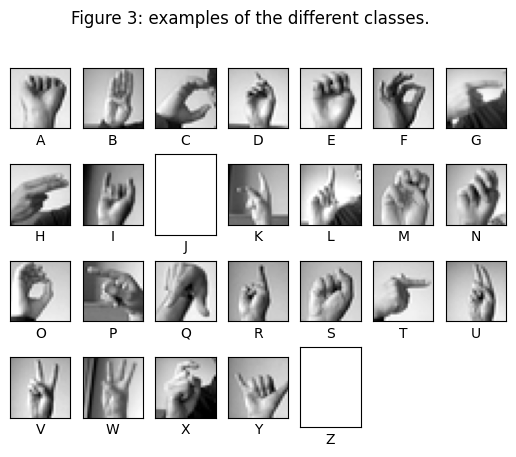

In [5]:
# define subplot
fig,axs = plt.subplots(4,7)
axs = axs.ravel()
j = 0
#loop through each subplot
for i in range(len(asl_alphabets)):
  # loop through class labels and plot 1 of each type of class
  if i not in list(y_train):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].grid(False)
    axs[i].set_xlabel(asl_alphabets[i])
    continue
  while i != y_train[j]:
    j+=1
  asl_alphabet = asl_alphabets[y_train[j]]
  # plot raw pixel data
  axs[i].set_xticks([])
  axs[i].set_yticks([])
  axs[i].grid(False)
  axs[i].imshow(X_train.iloc[j].to_numpy().reshape(28,28), cmap=plt.get_cmap('gray'))
  axs[i].set_xlabel(asl_alphabet)
# show the figure
for k in range(26,28):
  fig.delaxes(axs[k])
fig.suptitle('Figure 3: examples of the different classes.')
plt.show()

Figure 3 shows an example of each class where class **J** and class **Z** are missing values as they are deliberately excluded because they require motion. It is important to note that the example image of class **T** is incorrect.

***
2. Scale the image values appropriately.

The training and testing feature data sets are scaled by Min Max normalisation. The scaling is fitted to the training data, and then applied to both the training ansd testing data sets. The image data is reshaped to a 28 x 28 array.

In [6]:
import pandas as pd
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
#normalise training and testing data sets
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)
#reshape the features data to two dimensional arrays
X_train_scaled = X_train_scaled.reshape(-1,28,28,1)
X_test_scaled = X_test_scaled.reshape(-1,28,28,1)

***
3. Deal with missing labels by either making sure that the label values are continuous or converting to a representation where the numerical label values do not matter.

Represent the class values categorically as string labels.

In [7]:
from sklearn.preprocessing import LabelBinarizer
##Represent the numerical labels as categorical values
y_train_cat = y_train.map(asl_alphabets)
y_test_cat = y_test.map(asl_alphabets)

#Label Encoding
label_binarizer = LabelBinarizer()
y_train_trans = label_binarizer.fit_transform(y_train_cat)
y_test_trans = label_binarizer.transform(y_test_cat)
print(f'The binary representation of {y_train_cat[0]} is:')
y_train_trans[0]

The binary representation of D is:


array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

The classes are converted to a binary representation of the category. There are 24 different classes, and the integer representation is mapped to the category as a string. The categories are then expressed as a binary vector of dimensions **1x24**, comprising of 1's and 0's. The model is then trained with the classes in this representation and can be evaluated in the loss function. The inverse transform of LabelBinarizer is applied to the test data when evaluating and examining the confusion matrix.

***
4. Split the _test_ labels and images into separate validation and testing datasets according to a 50/50 split. We will use all of the training dataset for training.

In [8]:
# Splitting the testing data into seperate test and validation sets.
from sklearn.model_selection import train_test_split
X_test_scaled, X_validate, y_test_trans, y_validate = train_test_split(X_test_scaled,
                                                                       y_test_trans,
                                                                       test_size = 0.5,
                                                                       random_state=20,
                                                                       shuffle = True,
                                                                       stratify = y_test_trans )
print("x_test shape",X_test_scaled.shape)
print("x_validate shape",X_validate.shape)
print("y_test shape",y_test_trans.shape)
print("y_validate shape",y_validate.shape)

x_test shape (3586, 28, 28, 1)
x_validate shape (3586, 28, 28, 1)
y_test shape (3586, 24)
y_validate shape (3586, 24)


***
5. Question: Why are we splitting the test set up rather than the training set in this case?  Hint: look at the description of how the dataset is constructed.

The description of the dataset explains that the majority of the training dataset instances have been generated through an image augmentation process, based on a limited subset of images. It has also been suggested via the discussion by users of the data set that the train and test sets were not sampled from the same population. This results in a poor estimate of the generalisation error if the validation set is being sampled from the training data, aand will lead to overfitting of the model. The statistics of the distribution of the training data are possibly dissimilar to that of the testing data. This may have an impact in the final performance of the models, particular with Batch Normalisation layers as it behaves differently during training compared to during inference.

# 2. Build and train a CNN

1. Build a CNN using Keras that has the following settings:
 - Layers: Conv32 - MaxPooling - Conv64 - MaxPooling - Conv128 - MaxPooling - Flatten - Output
    - Note that Conv32 means a convolutional layer with 32 filters, etc.
 - 3x3 kernel size,
 - ReLU activation functions for hidden layers,
 - No dropout layers,
 - BatchNorm layers in appropriate places.

In [9]:
from tensorflow import keras
from keras.backend import clear_session
from keras.models import Sequential
from keras.layers import Input, Conv2D, Activation, BatchNormalization, MaxPooling2D, Flatten, Dense

# develop the model build function for the CNN
def cnn_build_func(convol_filters: list[int],regularisation = None):
  """
  Builds the Convolutional Neural Network based on a number of convolutions filter layers of different sizes.
  Arguments:
  convol_filters - A list of filter layers of number of filters per layer.
  regularisation - sets regularisation to a layer
  """
  clear_session()
  #creates a sequential model
  model = Sequential()
  #define the input size
  image_size = (28,28,1)
  #add the input layer
  model.add(Input(shape = image_size))
  for i,filter in enumerate(convol_filters):
    model.add(Conv2D(filters = filter,
                     kernel_size = (3,3),
                     strides = 1,
                     padding = "same",
                     activation ="relu",
                     kernel_regularizer = regularisation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2),strides = 2,padding = "same"))

  #flatten out the 2D image of XxY pixels to a linear layer
  model.add(Flatten())
  #output layer of 24 outputs
  model.add(Dense(24, activation = 'softmax'))
  return model

# define the number of convolutional layers each with the number of filters
convol_filters = [32,64,128]

model = cnn_build_func(convol_filters)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                        

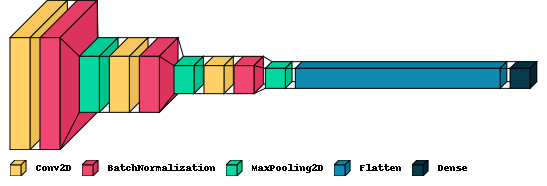

In [10]:
import visualkeras
visualkeras.layered_view(model, legend = True)

Figure 4 above gives a visual representation of the CNN's architecture.

***
2. Explain the reasoning behind your choice of placement for the BatchNorm
layers

The Batch Normalisation layer is placed after the ReLU activation function connected to the output of the convolution layer and before the MaxPooling layer. This allows the outputs of the convolutional filters to pass through non-linearity of the activation function before being normalised, helping the network learn complex, non-linear relationships. Batch Normalisation is placed before the pooling layer to ensure the activations are properly normalised before reducing the spatial dimensions of the feature maps, as this can introduce scale differences and distortions. By normalising the activations before pooling, the relative importance and distributions of features is maintained, which improve model performance and stability. Also, by normalising activations, the Batch Normalisation layer helps regularise the network and reduce overfitting.

***
3. Train this network using appropriate data and metrics. The following settings should be used in training:
 - Nadam optimiser,
 - Learning Rate Schedule exponential (see Module 4 Exercise),
 - Early stopping.

The learning rate under exponential decay is in the form:
$η=\eta_{o}.r^{t\over s}$,
where $r$ is the decay rate, $s$ is the decay factor and $t$ is the number of training epochs. The value for the decay rate is $ r = 0.1 $, which causes the learning rate, $\eta_{o}$, to decay to 10% of its previous value for every integer value of $t\over s$. As $s$ increases, the number of epochs needed to achieve the same decay rate of $r = 0.1$ is increased by a factor of $s$.

In [11]:
from math import exp, log, floor
from numpy.ma.core import argmax
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.optimizers import Nadam
from time import perf_counter

# Define exponential decay function.
def exp_decay(epoch):
  # During the first call, initialise, otherwise use the current value.
  if not hasattr(exp_decay,'s'):
    exp_decay.s = 1
  if not hasattr(exp_decay,'r'):
    exp_decay.r = 0.1
  if not hasattr(exp_decay,'eta0'):
    exp_decay.eta0 = 0.01
    #define the learning rate under exponential decay
  eta = exp_decay.eta0 * (exp_decay.r)**(epoch/exp_decay.s)
  return eta

# Create a callback using the learning rate scheduler
learning_rate_schedule = LearningRateScheduler(exp_decay)

# Early stopping callback - this is executed when fitting and will stop and restore best result
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=3,
                               min_delta = 0.001,
                               mode = "max",
                               restore_best_weights=True)
### training the CNN model
def cnn_training(convol_filters,
                 X_train,
                 X_validate,
                 y_train,
                 y_validate,
                 learning_rate,
                 early_stopping,
                 batch_size,
                 epochs,
                 verbose = 0,
                 regularisation = None):
  """
  Builds and fits the CNN model.
  Arguements:
  convol_filters - The list of integers giving the number of hidden layers per element and the size of the layer as the value.
  X_train - training data
  X_validate - validation data
  y_train - training class labels
  y_validate - validation class labels
  learning_rate - the Learning rate scheduler callback
  early_stopping - the Early stopping callback
  batch_size - The number of batches of samples in training.
  epochs - The number of cycles of training.
  verbose - detaild of training.
  regularisation = - L2 regularisation of kernel.
  """
  #initiate timer
  time_start = perf_counter()
  #build model
  model = cnn_build_func(convol_filters,regularisation)
  # compile the model
  model.compile(loss='categorical_crossentropy', optimizer='nadam',metrics=['accuracy'])
  #fit the model and record the training and validation history
  history = model.fit(x=X_train,
                      y=y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      callbacks=[learning_rate,early_stopping],
                      validation_data=(X_validate,y_validate),
                      verbose = verbose)
  #record the history of the training process as a dictionary
  learning_curve_data = history.history
  max_index = argmax(learning_curve_data['val_accuracy'])
  max_val_acc = learning_curve_data['val_accuracy'][max_index]
  epoch_max = len(learning_curve_data['val_accuracy'])
  #conclude timer
  time_end = perf_counter()
  timer = time_end - time_start
  print(f'The maximum validation accuracy achieved is: {max_val_acc*100: 0.2f}% after {epoch_max + 1} epochs, taking {timer: 0.1f} seconds')
  return (learning_curve_data, model)

# The number of epochs is set to an arbitrarily larger value due to the early stopping callback
epoch_limit = 30
# define model parameters
training_params = dict(convol_filters = convol_filters,
                       X_train = X_train_scaled,
                       X_validate = X_validate,
                       y_train = y_train_trans,
                       y_validate = y_validate,
                       learning_rate = learning_rate_schedule,
                       early_stopping = early_stopping,
                       batch_size = 100,
                       epochs = epoch_limit,
                       regularisation = None)

The learning rate scheduler depends on the exponential decay function and the decay factor parameter, $s$, is to be tuned. A range of values of $s$ are to be examined. The process of looping through a range of decay factors and training the model is repeated to examine variability.

In [12]:
#define a range of decay factors
decay_factors = [1, 2, 3, 5, 8, 10]
repeats = 3
new_line = '\n'
for i in range(repeats):
  print(f'Experiment {i+1}:{new_line}')
  #initialise lists to store objects
  results1 = []
  # Train with each learning rate scheduler parameter
  for decay_factor in decay_factors:
    # Set decay factor
    exp_decay.s = decay_factor
    # build and train the CNN model
    print(f'The decay factor is {exp_decay.s}')
    # build and train the cnn model
    result,model = cnn_training(**training_params)
    #save result for analysis
    results1.append(result)

Experiment 1:

The decay factor is 1
The maximum validation accuracy achieved is:  96.24% after 8 epochs, taking  38.0 seconds
The decay factor is 2
The maximum validation accuracy achieved is:  95.18% after 8 epochs, taking  23.5 seconds
The decay factor is 3
The maximum validation accuracy achieved is:  94.79% after 7 epochs, taking  20.1 seconds
The decay factor is 5
The maximum validation accuracy achieved is:  95.54% after 7 epochs, taking  24.0 seconds
The decay factor is 8
The maximum validation accuracy achieved is:  95.68% after 9 epochs, taking  28.5 seconds
The decay factor is 10
The maximum validation accuracy achieved is:  95.96% after 11 epochs, taking  24.3 seconds
Experiment 2:

The decay factor is 1
The maximum validation accuracy achieved is:  94.12% after 7 epochs, taking  34.7 seconds
The decay factor is 2
The maximum validation accuracy achieved is:  95.12% after 7 epochs, taking  22.2 seconds
The decay factor is 3
The maximum validation accuracy achieved is:  95.8

For each repeat of the parameter sweep of the decay factor, $s$, different values return a model with the greatest validation accuracy. This suggests the stochastic nature of the training process leads to a greater variability than what is achieved by the training under different learning rate decay factors. The learning curves of the model under the different learning rate decay factors is given below.

***
4. Display the learning curves, confusion matrix and final performance values.

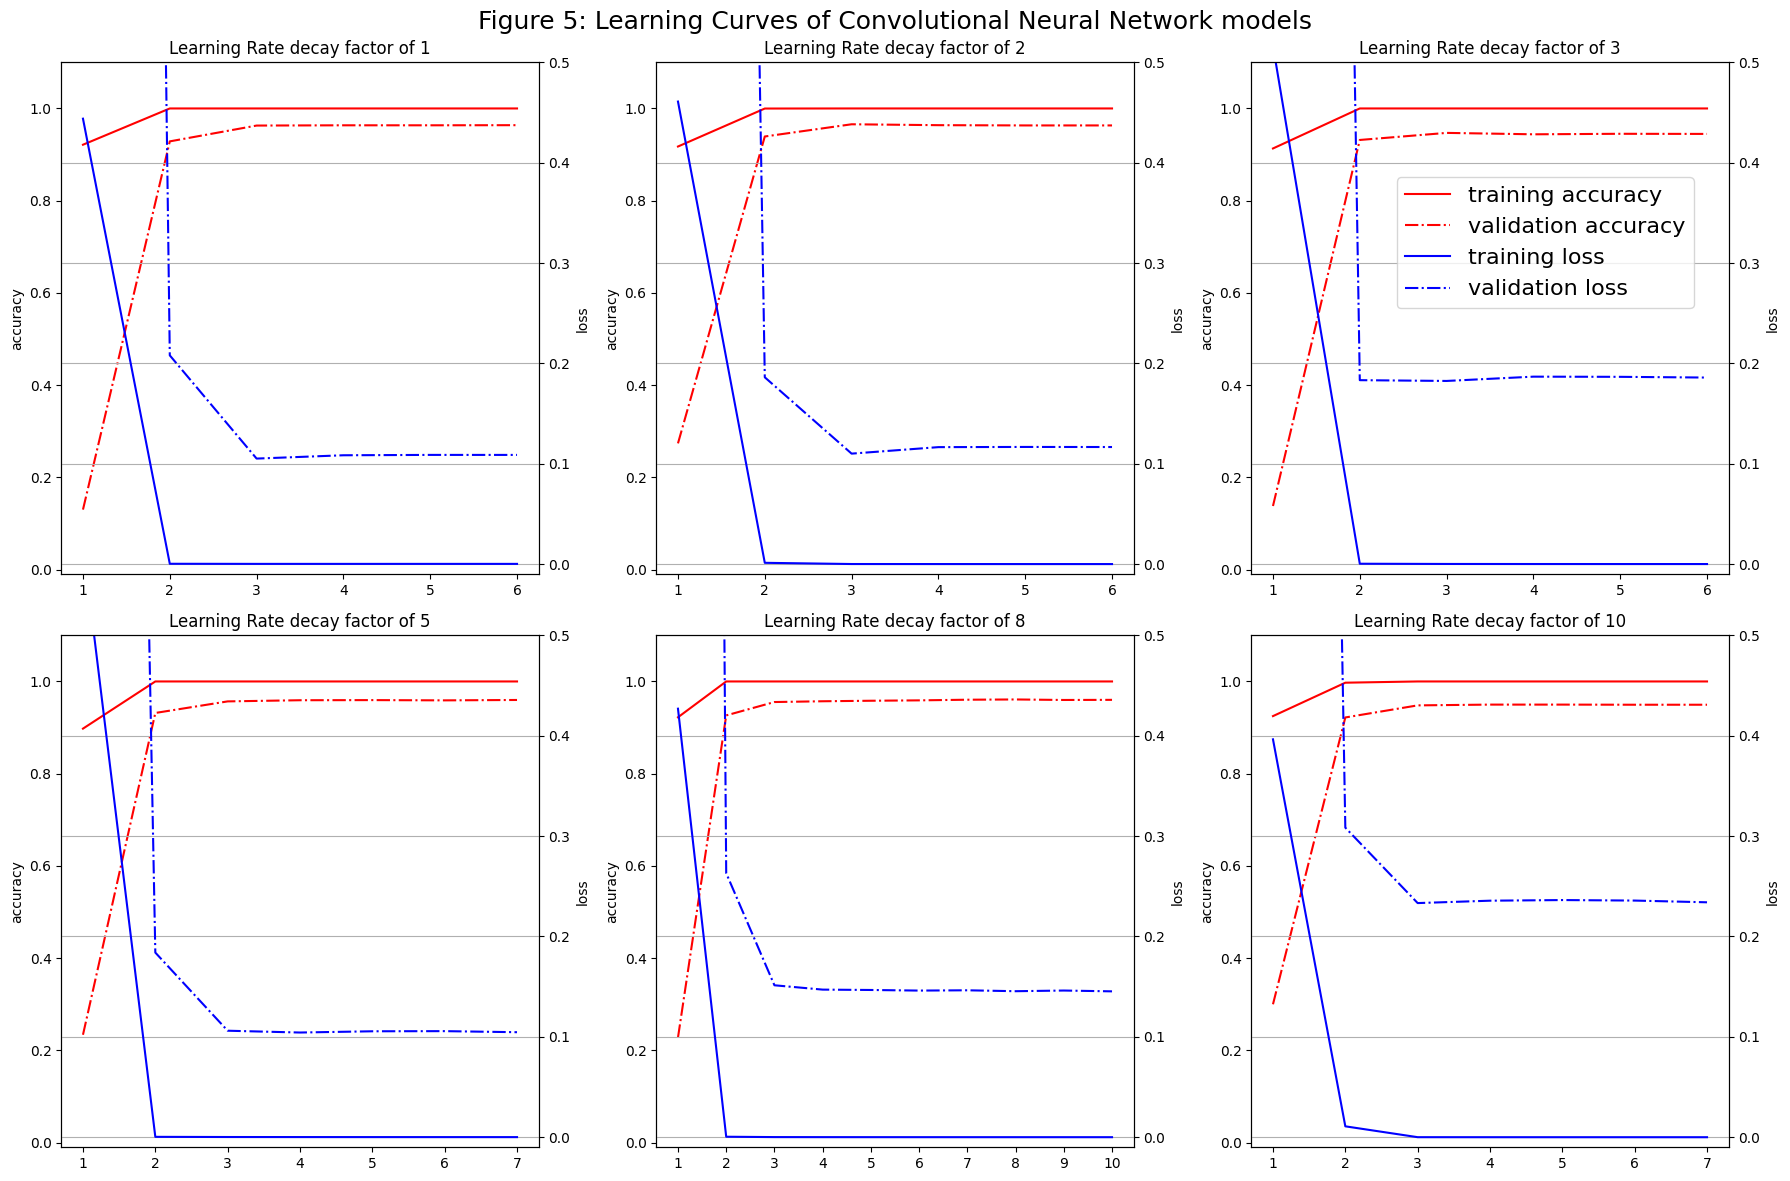

In [13]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
fig,axs = plt.subplots(2,3,figsize = (18,12))
axs = axs.ravel()
lines = ['-r','-.r','-b','-.b']
labels = ['training accuracy','validation accuracy','training loss','validation loss']
for i,ax in enumerate(axs):
  decay_factor = decay_factors[i]
  epochs = [x for x in range(1,len(results1[i]['val_accuracy'])+1)]
  #define the current dictionary
  data = results1[i].copy()
  # define the number of epochs
  data['epochs'] = epochs

  #plot the accuracy metric
  l1, = ax.plot('epochs','accuracy',lines[0],data = data,label = labels[0])
  l2, = ax.plot('epochs','val_accuracy',lines[1],data = data,label = labels[1])
  ax.grid(False)
  ax2 = ax.twinx()
  l3, = ax2.plot('epochs','loss',lines[2], data = data,label = labels[2])
  l4, = ax2.plot('epochs','val_loss',lines[3], data = data,label = labels[3])
  ax2.grid(True)
  #label the axis
  ax.set_ylabel("accuracy")
  #set the range on the axis
  ax.set_ylim(-0.01,1.1)
  ax2.set_ylabel("loss")
  ax2.set_ylim(-0.01,0.5)
  # Add sub titles per graph
  ax.set_title(f"Learning Rate decay factor of {decay_factor}",size = 12)
  #have x-axis as integer tick labels
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#Add main title for figure
fig.suptitle("Figure 5: Learning Curves of Convolutional Neural Network models",size = 18)
#position the legend
fig.legend((l1,l2,l3,l4), labels, loc='outside right upper',bbox_to_anchor=(0.95, 0.85),prop={'size': 16})
fig.tight_layout()
#produces the graph
plt.show()

Figure 5 shows learning curves of the training of the CNN models with different learning rate decay factors. All the validation accuracy curves rise to a peak and plateau to approximately the same value, showing no clear distinction. However, for high decay factor values such as $s = 10$ or low decay values, validation loss decreases to some local minimum and then slowly begins to rise as the number of epochs increases. This suggests the model learning becomes unstable. This is most obvious in the learning rate with decay factors 2. In fact, the CNN model with learning rate decay factors of 5 has the lowest validation loss.

For the best decay factor, $s = 5$, the batch size is to be tuned. A model is build and trained for a range of batch size values for the optimizer.

In [14]:
#build and train the cnn model for different batch sizes
batch_sizes = [16, 32, 64, 128, 256, 512]
#initialise lists to store objects
results2 = []
models2 = []
# Set decay factor
exp_decay.s = 5
# loop through each batch size
for batch_size in batch_sizes:
  # build and train the CNN model
  print(f'The batch size is {batch_size}')
  training_params['batch_size'] = batch_size
  result,model = cnn_training(**training_params)
  #save result for analysis
  results2.append(result)
  models2.append(model)

The batch size is 16
The maximum validation accuracy achieved is:  95.79% after 6 epochs, taking  53.5 seconds
The batch size is 32
The maximum validation accuracy achieved is:  96.24% after 9 epochs, taking  76.4 seconds
The batch size is 64
The maximum validation accuracy achieved is:  95.32% after 7 epochs, taking  20.9 seconds
The batch size is 128
The maximum validation accuracy achieved is:  95.84% after 10 epochs, taking  21.3 seconds
The batch size is 256
The maximum validation accuracy achieved is:  94.87% after 12 epochs, taking  21.1 seconds
The batch size is 512
The maximum validation accuracy achieved is:  94.42% after 21 epochs, taking  29.1 seconds


The CNN model training with a batch size of 128 appears to return the largest validation accuracy. Learning curves of the CNN model training for the selected batch sizes is given below.

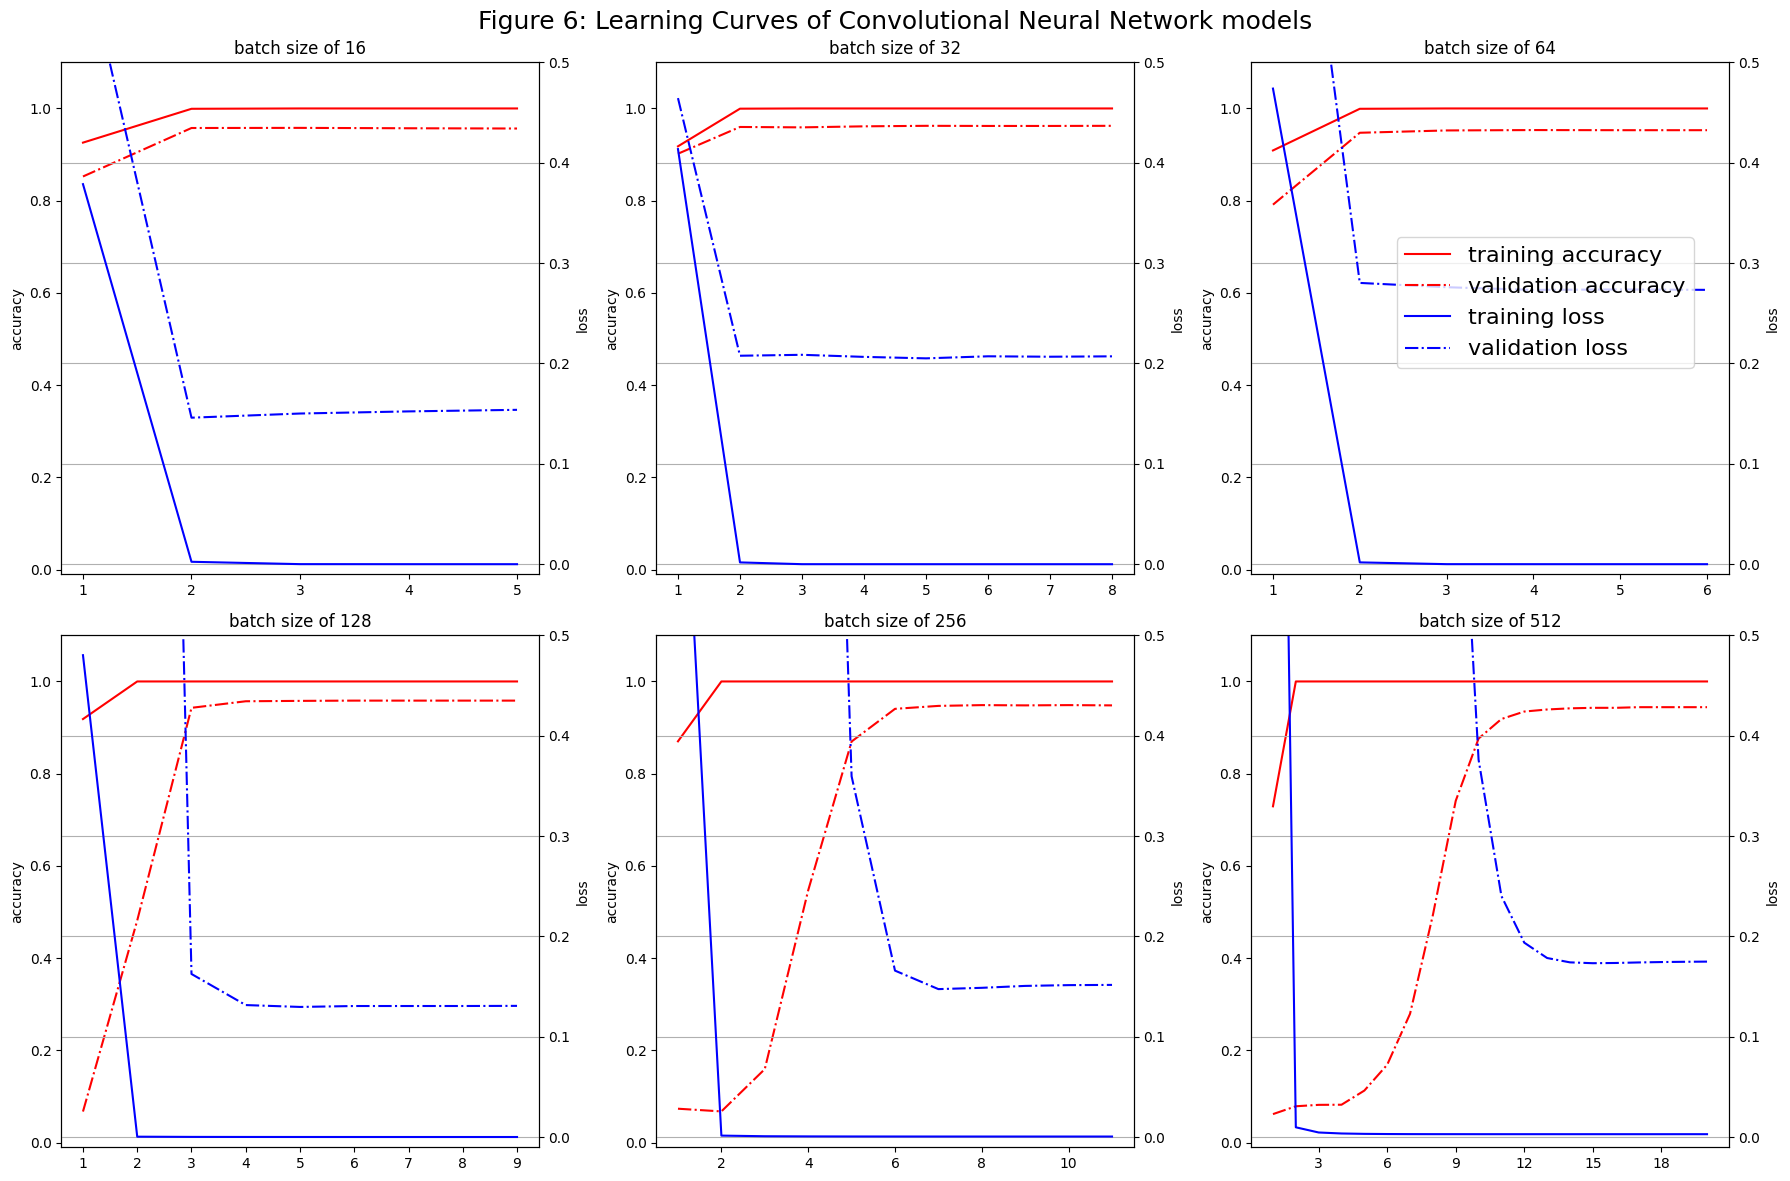

In [15]:
fig,axs = plt.subplots(2,3,figsize = (18,12))
axs = axs.ravel()
lines = ['-r','-.r','-b','-.b']
labels = ['training accuracy','validation accuracy','training loss','validation loss']

for i,ax in enumerate(axs):
  batch_size = batch_sizes[i]
  epochs = [x for x in range(1,len(results2[i]['val_accuracy'])+1)]
  #define the current dictionary
  data = results2[i].copy()
  # define the number of epochs
  data['epochs'] = epochs
  #plot the accuracy metric
  l1, = ax.plot('epochs','accuracy',lines[0],data = data,label = labels[0])
  l2, = ax.plot('epochs','val_accuracy',lines[1],data = data,label = labels[1])
  ax.grid(False)
  ax2 = ax.twinx()
  l3, = ax2.plot('epochs','loss',lines[2], data = data,label = labels[2])
  l4, = ax2.plot('epochs','val_loss',lines[3], data = data,label = labels[3])
  ax2.grid(True)
  #label the axis
  ax.set_ylabel("accuracy")
  #set the range on the axis
  ax.set_ylim(-0.01,1.1)
  ax2.set_ylabel("loss")
  ax2.set_ylim(-0.01,0.5)
  # Hide grid lines
  ax.set_title(f"batch size of {batch_size}",size = 12)
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))
fig.suptitle("Figure 6: Learning Curves of Convolutional Neural Network models",size = 18)
#position the legend
fig.legend((l1,l2,l3,l4), labels, loc='outside right upper',bbox_to_anchor=(0.95, 0.8),prop={'size': 16})
fig.tight_layout()
#produces the graph
plt.show()

Inspecting the learning curves given in figure 6, the CNN model trained with a batch size of 128 gives the lowest validation loss that remain stable and at a minimum as epochs increase. The validation accuracy plateaus to a maximum by the 4th epoch. It is noted that as the batch size increases, particularly for 256 and greater, the validation loss curve drops to a local minimum then begins to increase as number of epochs increase, all while accuracy plateaus at its maximum. This suggests the CNN models for these batch sizes is less stable for increasing number of epochs. The model is clearly converging much slowly when learning with batch sizes of 512, as metrics only begin to flatten at epochs 15 or greater.
 Consquently, the best batch size for training the CNN is 128.

The confusion matrix for the CNN model  is given below

113/113 [==============================] - 0s 2ms/step


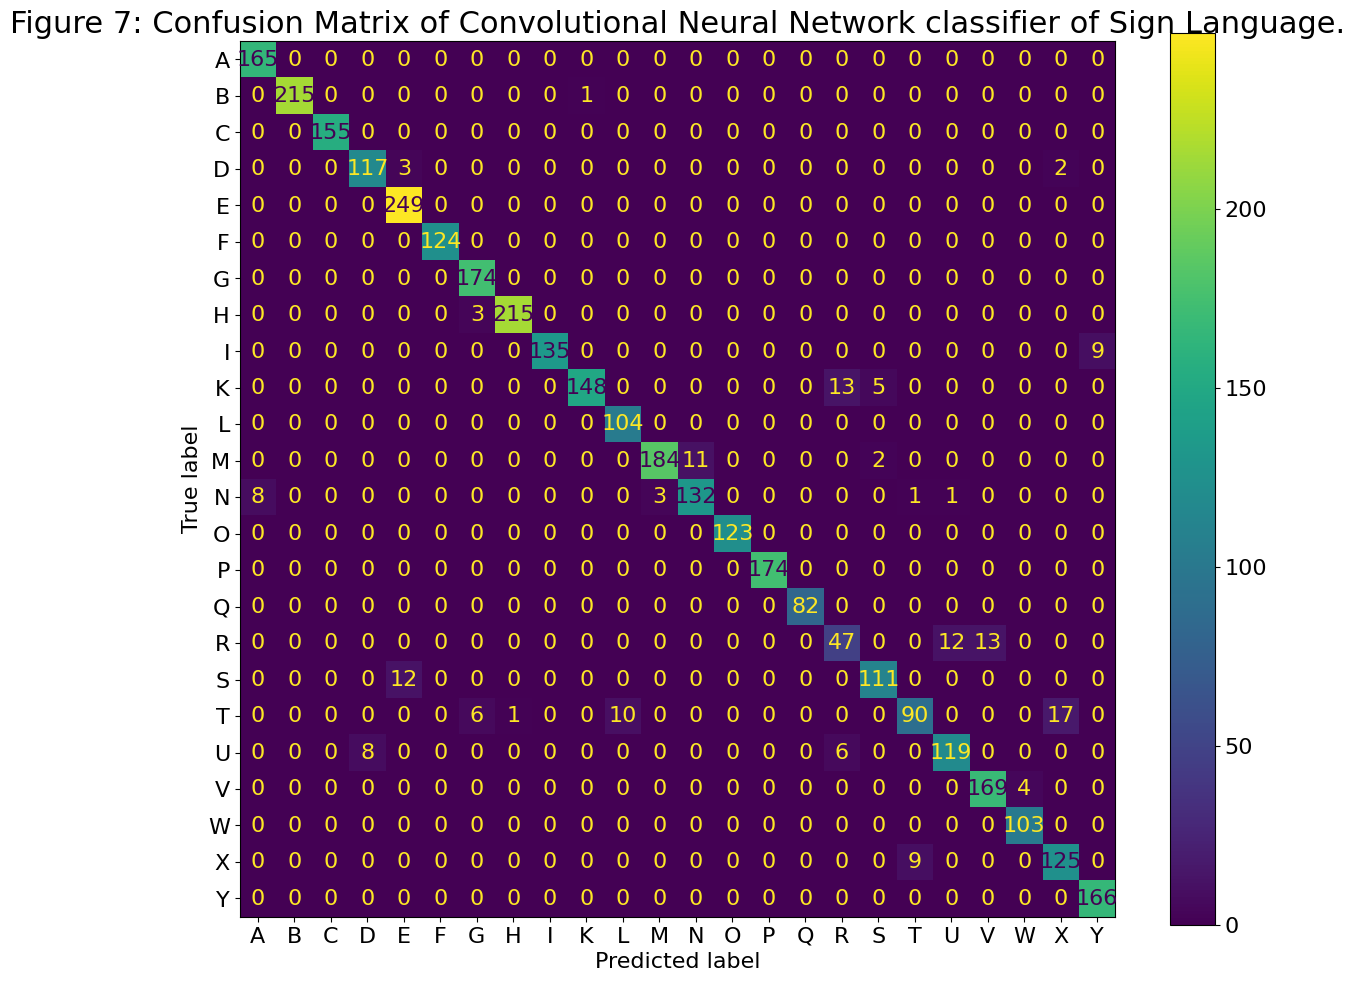

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
class_labels = {'A','B','C','D','E', 'F', 'G','H', 'I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y'}
best_base_model = models2[3] # for batch size of 64
# predictions of classes using the test data set
prediction_probs = best_base_model.predict(X_test_scaled)
#determine the class with the highest probability score as a numerical label from 0 to 24
prediction_labels = label_binarizer.inverse_transform(prediction_probs)
#determine the class with a label from 0 to 24 from binary encoded y_test data set
y_test_labels = label_binarizer.inverse_transform(y_test_trans)
# Evaluate the predictions by analysing the confusion matrix.
cm = confusion_matrix(y_test_labels,prediction_labels)
#Initialise the figure of the Confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
ax.grid(False)
#Set title and font size of the Confusion Matrix
plt.title("Figure 7: Confusion Matrix of Convolutional Neural Network classifier of Sign Language.",{'fontsize': 22})
plt.rc('font', **{'size':16})
#Display confusion matrix from the predictions on the testing data set
ConfusionMatrixDisplay.from_predictions(y_test_labels,prediction_labels,ax=ax )
fig.tight_layout()


In [40]:
#initialise a model performance array
model_performance = np.zeros((3,3))
#Evaluation of the model
new_line = '\n'
base_model_scores = best_base_model.evaluate(X_test_scaled,y_test_trans)
print(f'Accuracy of the model is -  {base_model_scores[1]*100: 0.2f}%{new_line}\
The Loss of the model is - {base_model_scores[0]:0.4f}{new_line}\
The total number of parameters for the model is {best_base_model.count_params()}')
#model 1 - base CNN model
model_performance[0][0] = base_model_scores[0]
model_performance[0][1] = base_model_scores[1]
model_performance[0][2] = best_base_model.count_params()

113/113 [==============================] - 0s 3ms/step - loss: 0.1457 - accuracy: 0.9554
Accuracy of the model is -   95.54%
The Loss of the model is - 0.1457
The total number of parameters for the model is 142744


Figure 7 shows that when the True class is $T$ and the CNN model incorrectly makes a prediction, it predict a $X$ at a maximum of 17 instances. While if the True class is a $X$ and the model incorrectly makes a prediction, it will predict a $T$ 100% of the time.
Also, if the true class is a $R$ and the CNN model incorrectly makes a prediction, it will mostly predict a $U$ and $V$.

# 3. Hyper-parameter optimisation

Take the base network from the previous part and perform separate hyper-parameter optimisation over the following 2 choices. In both cases leave all other configurations constant.

1. Optimise the L2 regularisation on the kernels in all layers. Test the following weight values: 1e-5, 1e-4, 1e-3, 1e-2, 1e-1.

In [41]:
from keras.regularizers import L2
# define the number of convolutional layers each with the number of filters
convol_filters = [32,64,128]
# Set decay factor
exp_decay.s = 5
# define the base model parameters to be maintained for hyperparameter tuning
base_model_params =  dict(convol_filters = convol_filters,
                          X_train = X_train_scaled,
                          X_validate = X_validate,
                          y_train = y_train_trans,
                          y_validate = y_validate,
                          learning_rate = learning_rate_schedule,
                          early_stopping = early_stopping,
                          batch_size = 64, # As decided from Learning curve
                          epochs = epoch_limit,
                          regularisation = None)
#define the range of weights
L2_weight_values = [10**(-x) for x in range(1,6)]
results3 = []
#loop through each weight value in the list
for L2_weight_value in L2_weight_values:
  #define regularisation
  regularisation = L2(L2_weight_value)
  #define model parameters
  base_model_params['regularisation'] = regularisation
  # train the model and store training history
  result,model = cnn_training(**base_model_params)
  #record results and models for analysis
  results3.append(result)


The maximum validation accuracy achieved is:  95.65% after 13 epochs, taking  41.9 seconds
The maximum validation accuracy achieved is:  93.50% after 8 epochs, taking  25.2 seconds
The maximum validation accuracy achieved is:  95.73% after 18 epochs, taking  75.0 seconds
The maximum validation accuracy achieved is:  94.81% after 7 epochs, taking  21.5 seconds
The maximum validation accuracy achieved is:  95.71% after 10 epochs, taking  28.9 seconds


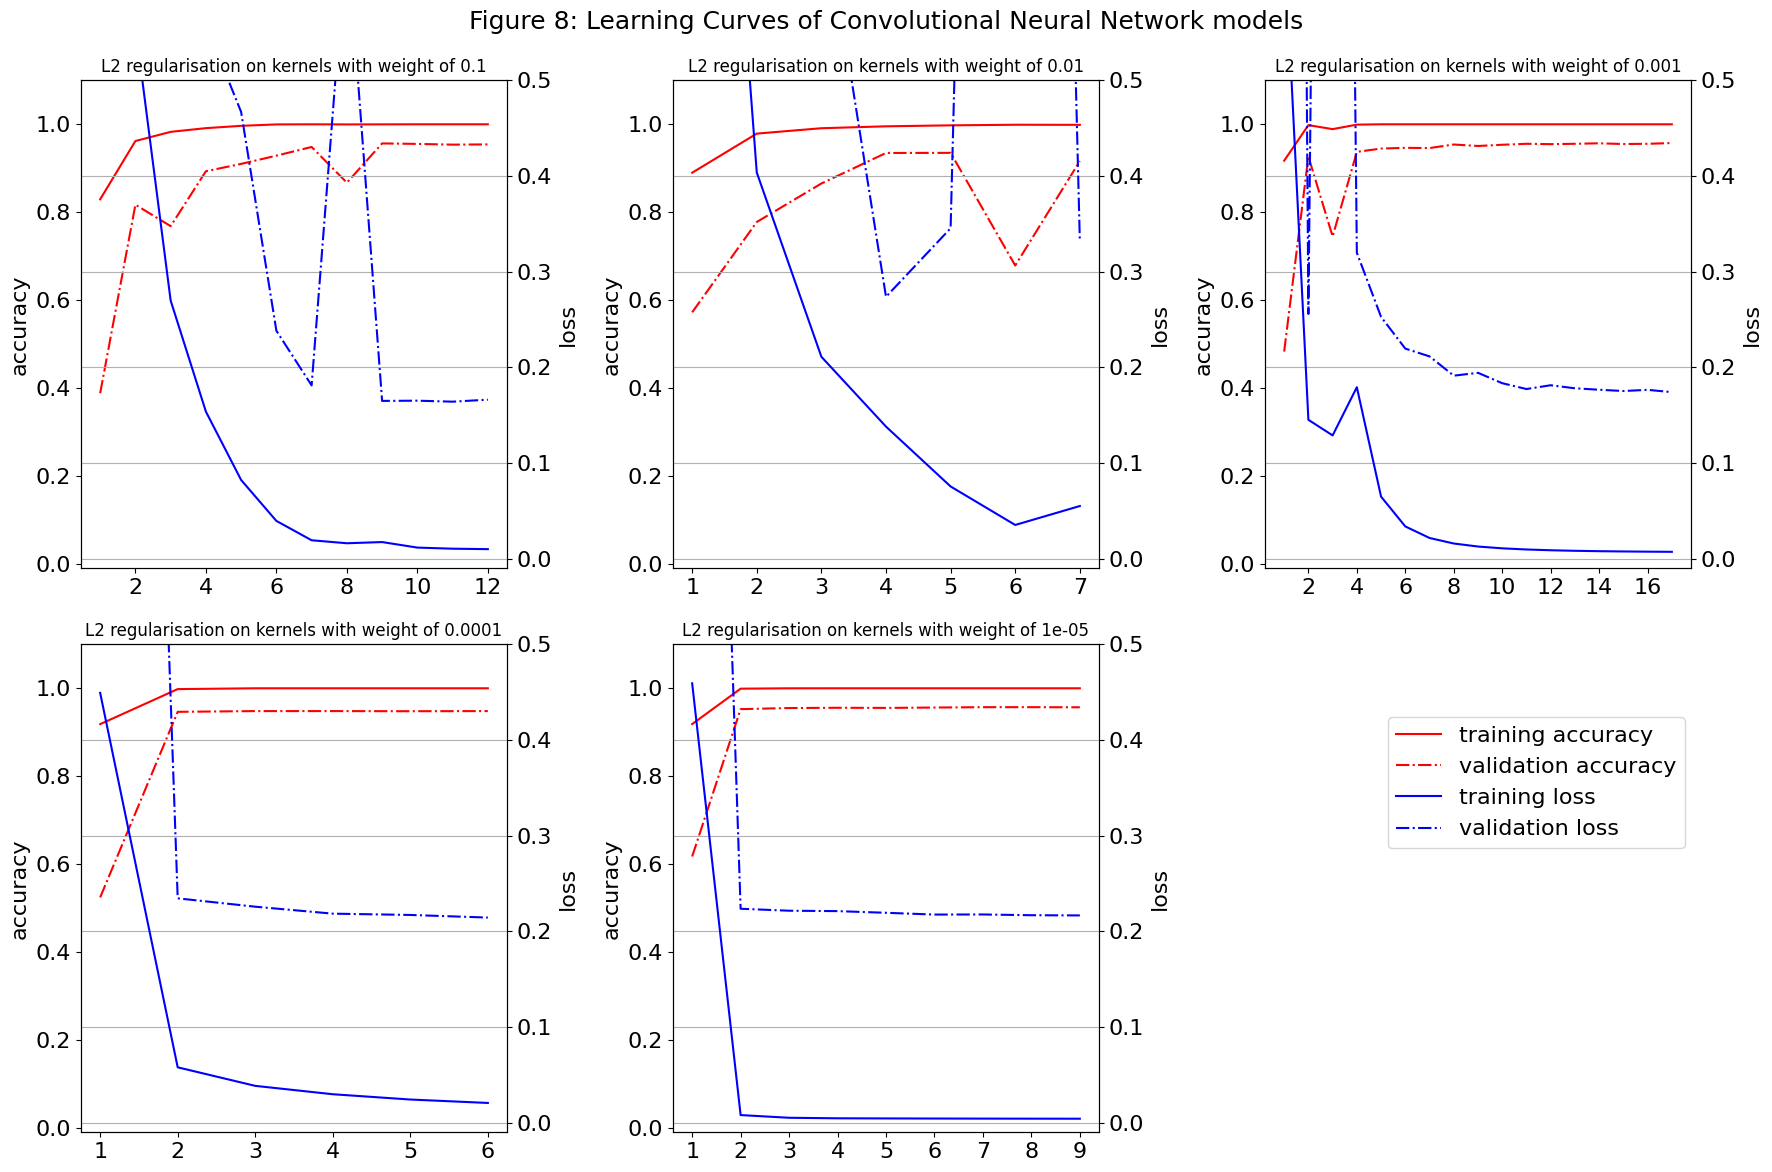

In [42]:
fig,axs = plt.subplots(2,3,figsize = (18,12))
axs = axs.ravel()
lines = ['-r','-.r','-b','-.b']
labels = ['training accuracy','validation accuracy','training loss','validation loss']

for i,ax in enumerate(axs):
  if i < len(L2_weight_values):
    L2_weight_value = L2_weight_values[i]
    epochs = [x for x in range(1,len(results3[i]['val_accuracy'])+1)]
    #define the current dictionary
    data = results3[i].copy()
    # define the number of epochs
    data['epochs'] = epochs
    #plot the accuracy metric
    l1, = ax.plot('epochs','accuracy',lines[0],data = data,label = labels[0])
    l2, = ax.plot('epochs','val_accuracy',lines[1],data = data,label = labels[1])
    ax.grid(False)
    ax2 = ax.twinx()
    l3, = ax2.plot('epochs','loss',lines[2], data = data,label = labels[2])
    l4, = ax2.plot('epochs','val_loss',lines[3], data = data,label = labels[3])
    ax2.grid(True)
    #label the axis
    ax.set_ylabel("accuracy")
    #set the range on the axis
    ax.set_ylim(-0.01,1.1)
    ax2.set_ylabel("loss")
    ax2.set_ylim(-0.01,0.5)
    # Hide grid lines
    ax.set_title(f"L2 regularisation on kernels with weight of {L2_weight_value}",size = 12)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
fig.suptitle("Figure 8: Learning Curves of Convolutional Neural Network models",size = 18)
# delete 6th axis
fig.delaxes(axs[5])
#position the legend
fig.legend((l1,l2,l3,l4), labels, loc='outside right upper',bbox_to_anchor=(0.95, 0.4),prop={'size': 16})
fig.tight_layout()
#produces the graph
plt.show()

Figure 8 gives the learning curves of the CNN model under different L2 regularisation weights on kernels of hidden layers. A weight of $10^{-5}$ achieves a plateaued validation accuracy that is most stable, the highest and closest to training accuracy. The learning curve for weight of $10^{-5}$ also gives a validation loss that is most stable, plateaus to a minimum  and converges in less epochs. Also, L2 weights greater than $10^{-4}$ lead to the training of models to be unstable.

2. Try a different number of layers and layer sizes.  In particular do the following: (a) smaller layer sizes (Conv16, Conv32, Conv64); (b) two layers only (Conv32, Conv64); (c) two layers and smaller sizes (Conv16, Conv32)

In [44]:
# define the range of different network architecture with number of convolutional layers each with the number of filters.
convol_filters_range ={"smaller layer sizes 1": [8,16,32],
                       "smaller layer sizes 2": [16,32,64],
                       "two layers only": [32,64],
                       "two layers and smaller sizes 1": [16,32],
                       "two layers and smaller sizes 2": [8,16]}
# use the no regularisation setting  of the base model for comparing the models of different sizes

# define the base model parameters to be maintained for hyperparameter tuning
base_model_params =  dict(convol_filters = convol_filters,
                          X_train = X_train_scaled,
                          X_validate = X_validate,
                          y_train = y_train_trans,
                          y_validate = y_validate,
                          learning_rate = learning_rate_schedule,
                          early_stopping = early_stopping,
                          batch_size = 128, # As decided from Learning curve
                          epochs = epoch_limit,
                          regularisation = None) # setting for base model
results4 = []
#loop through each weight value in the list
for key,value in convol_filters_range.items():
   #define model parameters
  base_model_params['convol_filters'] = value
  # train the model and store training history
  result,model = cnn_training(**base_model_params)
  #record results and models for analysis
  results4.append(result)

The maximum validation accuracy achieved is:  93.98% after 8 epochs, taking  14.0 seconds
The maximum validation accuracy achieved is:  94.53% after 7 epochs, taking  13.5 seconds
The maximum validation accuracy achieved is:  92.64% after 11 epochs, taking  17.0 seconds
The maximum validation accuracy achieved is:  91.86% after 8 epochs, taking  12.0 seconds
The maximum validation accuracy achieved is:  87.06% after 14 epochs, taking  19.7 seconds


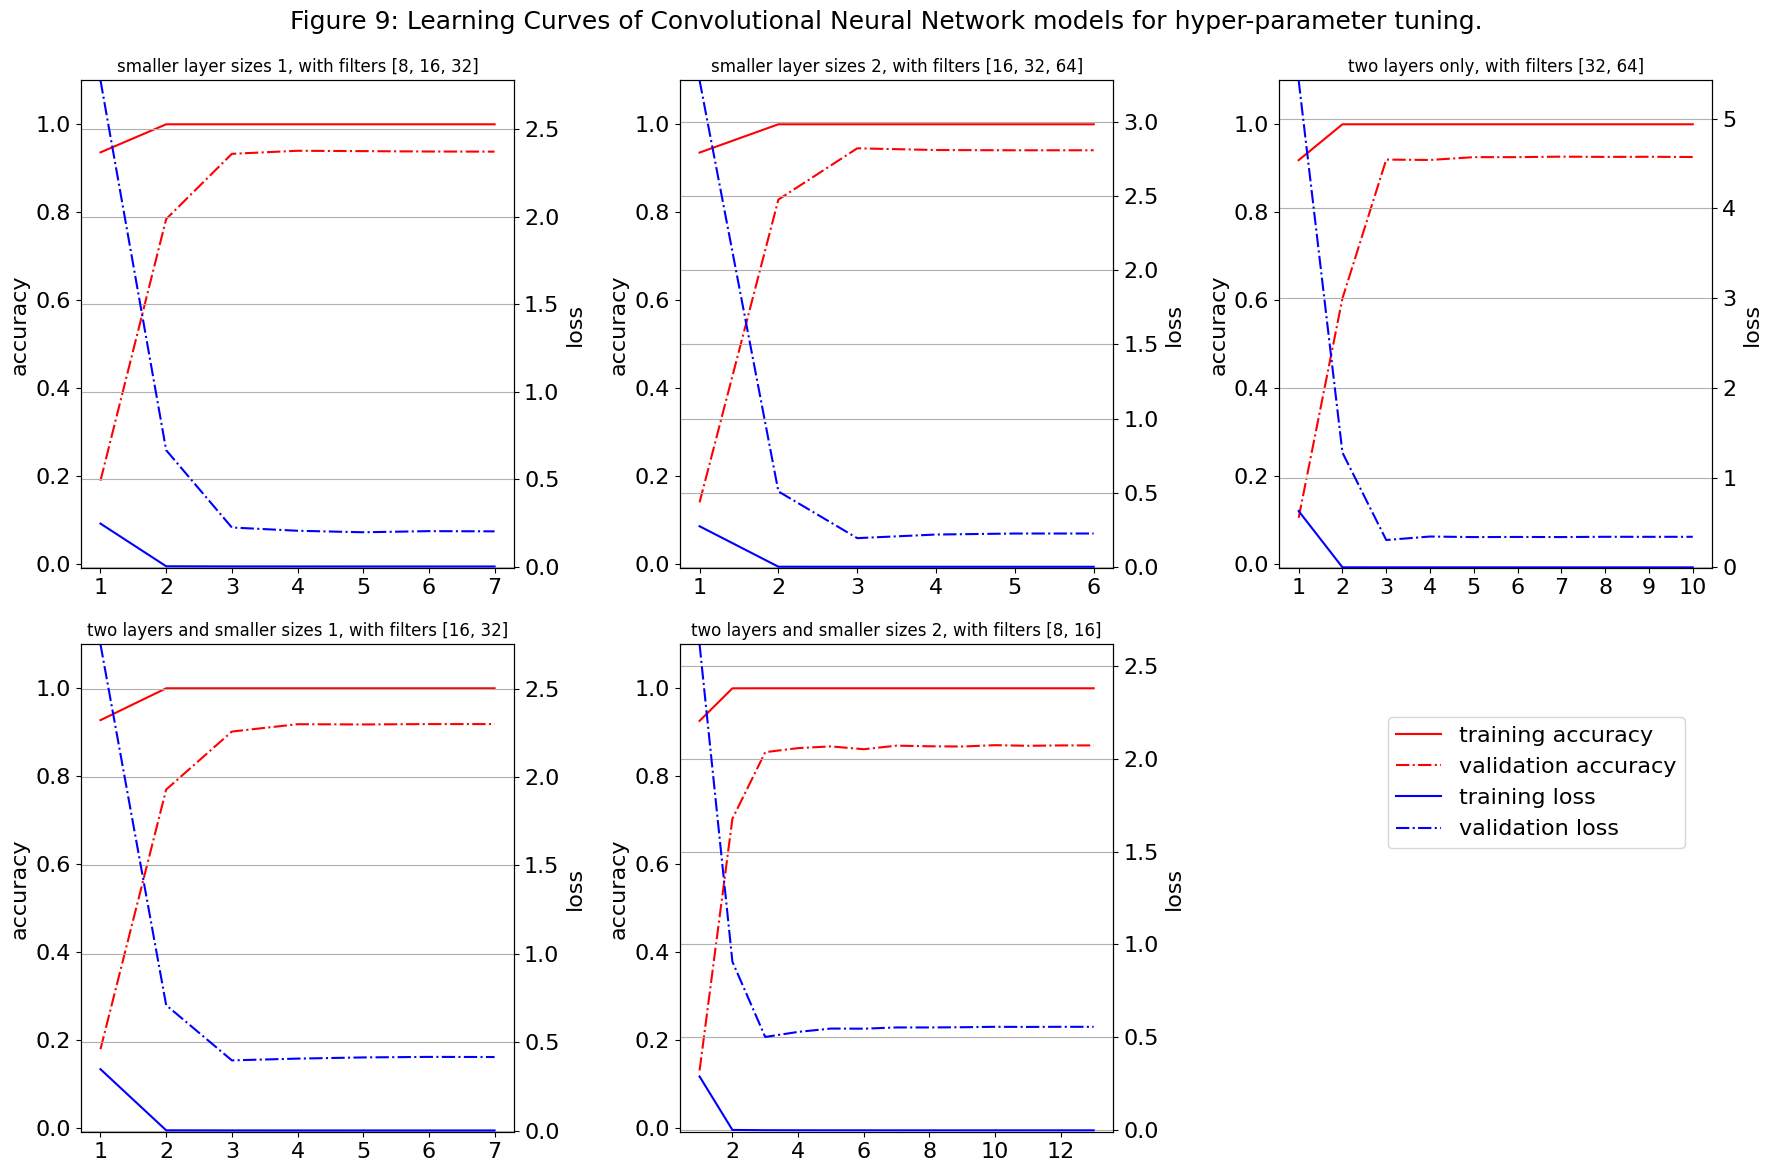

In [45]:
fig,axs = plt.subplots(2,3,figsize = (18,12))
axs = axs.ravel()
lines = ['-r','-.r','-b','-.b']
labels = ['training accuracy','validation accuracy','training loss','validation loss']

for i,ax in enumerate(axs):
  if i < len(convol_filters_range):
    keys_list = list(convol_filters_range.keys())
    convol_filters = convol_filters_range[keys_list[i]]
    epochs = [x for x in range(1,len(results4[i]['val_accuracy'])+1)]
    #define the current dictionary
    data = results4[i].copy()
    # define the number of epochs
    data['epochs'] = epochs
    #plot the accuracy metric
    l1, = ax.plot('epochs','accuracy',lines[0],data = data,label = labels[0])
    l2, = ax.plot('epochs','val_accuracy',lines[1],data = data,label = labels[1])
    ax.grid(False)
    ax2 = ax.twinx()
    l3, = ax2.plot('epochs','loss',lines[2], data = data,label = labels[2])
    l4, = ax2.plot('epochs','val_loss',lines[3], data = data,label = labels[3])
    ax2.grid(True)
    #label the axis
    ax.set_ylabel("accuracy")
    #set the range on the axis
    ax.set_ylim(-0.01,1.1)
    ax2.set_ylabel("loss")
    max_loss = max(results4[i]['val_loss'])
    ax2.set_ylim(-0.01,max_loss)
    # Hide grid lines
    ax.set_title(f"{keys_list[i]}, with filters {convol_filters}",size = 12)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
fig.suptitle("Figure 9: Learning Curves of Convolutional Neural Network models for hyper-parameter tuning.",size = 18)
# delete 6th axis
fig.delaxes(axs[5])
#position the legend
fig.legend((l1,l2,l3,l4), labels, loc='outside right upper',bbox_to_anchor=(0.95, 0.4),prop={'size': 16})
fig.tight_layout()
#produces the graph
plt.show()

Figure 9 show learning curves for the CNN model training under different architecture of number of convolutional layetrs and number of filters at each layer. The architecture labels *smaller layer sizes 2* with convolutional filters of $[16, 32, 64]$ gives the most stable validation accuracy that is highest in value and closest to training accuracy. Also the validation loss for this architecture is the lowest and most stable by comparison.

3. Display your results as two plots of the performance versus the hyper-parameter value(s). Practice unambiguous and organised visualisation, by labelling the axis, using a legend, title, axis limits and suitable marker and line styles. Make sure to choose the axis limits, such that the important parts of the data are clearly visible.

<ipython-input-46-78a7b3b0c772>:32: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color('blue')


Text(0.5, 1, 'Figure 10: The summary of performance of the CNN range of hyperparameter values.')

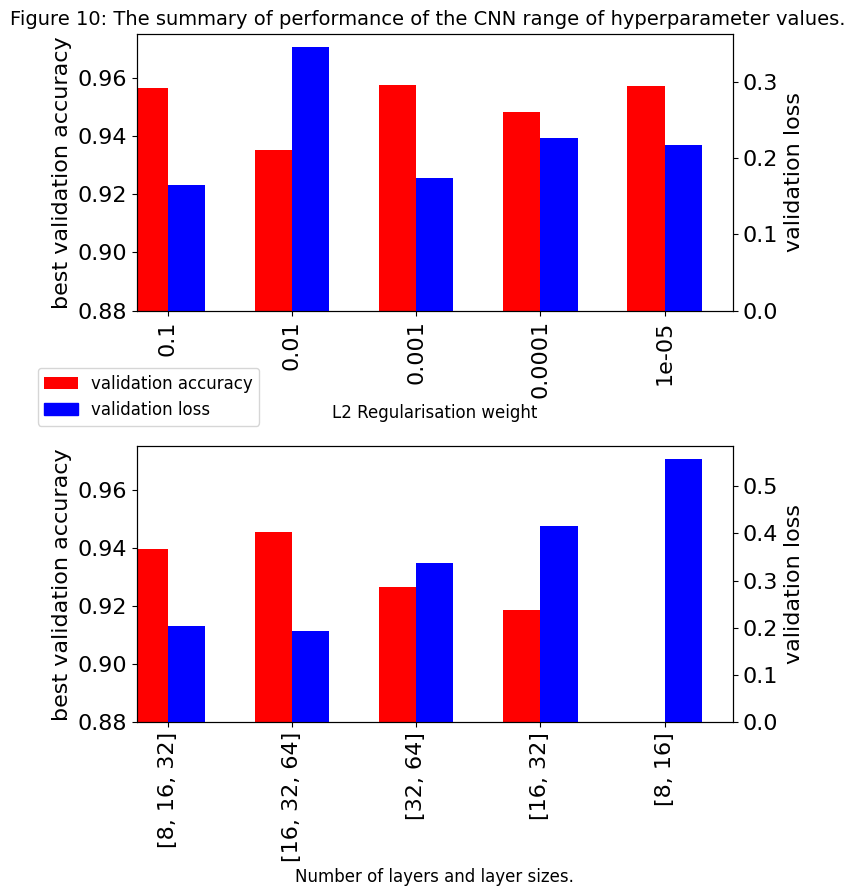

In [46]:
from numpy.ma.core import argmax
#initialise the figure
fig,axs = plt.subplots(2,1,figsize = (8,9))
results_list = [results3,results4]
hyperparameter_values = [[str(x) for x in L2_weight_values], [v for k,v in convol_filters_range.items()]]
hparameter_label = ['L2 Regularisation weight','Number of layers and layer sizes.']
axs = axs.ravel()
#loop through each set of results of training histories for hyperparameter tuning
for i,(ax,results) in enumerate(zip(axs,results_list)):
#loop through each training history and corresponding number of nodes in first layer
  accuracy_list = []
  loss_list = []
  for train_h in results:
    #find the index of maximum accuracy achieved in training.
    max_index = argmax(train_h['val_accuracy'])
    #record the maximum validation accuracy achieved from training
    accuracy_list.append(train_h['val_accuracy'][max_index])
    #record the corresponding loss achieved from training
    loss_list.append(train_h['val_loss'][max_index])
  # collate plotable data as pandas dataframe
  xvalues = np.arange(len(accuracy_list))
  df = pd.DataFrame(np.c_[xvalues,accuracy_list,loss_list],
                    columns=["xvalues","yvalues1","yvalues2"])
  # plot the max accuracy and corresponding loss values for validation for each hyperparameter value
  df.plot.bar(x ="xvalues",y = "yvalues1",color = 'red', ax=ax, width=0.3,legend = False,ylabel = 'best validation accuracy', position=1,)
  ax2 = ax.twinx()
  df.plot.bar(x ="xvalues" ,y = "yvalues2", color='blue', ax=ax2, width=0.3,legend = False,ylabel = 'validation loss', position=0)
  ax.set_xlabel(hparameter_label[i],fontsize=12)
  ax.set_ylim(0.88,0.975)
  ax2.set_xticklabels(hyperparameter_values[i])
leg = fig.legend(['validation accuracy','validation loss'], loc=7,fontsize="12", bbox_to_anchor=(0.3,0.57),)
leg.legendHandles[1].set_color('blue')
fig.tight_layout()
fig.suptitle("Figure 10: The summary of performance of the CNN range of hyperparameter values.",size = 14,y=1)

Figure 10 summarises the maximum validation accuracy achieved by the CNN model during training together with the corresponding validation loss for each value of the target hyperparameter. The desired outcome is the hyperparameter that gives the greatest validation accuracy (red bar) with lowest validation loss (blue bar), however this needs to be interpreted in context of the stability of training through examining learning curves as seen in figures 8 and 9.

4. Question: What are the best hyper-parameter values to use? Where can we see this in the diagrams and outputs generated above?

THe CNN under hyperparameter tuning performs best with a 3 convolutional layer architecture  of smaller layer sizes, that is, with 16, 32 and 64 convolutional filters respectively. This is noted in figure 10b, showing a maximum validation accuracy of 95.4% together with the lowest validation loss that is less than 0.2. The corresponding learning curve in figure 9 shows stable, converged training with a maximum validation accuracy most closest to its corresponding training accuracy, together with the lowest converged validation loss.
The CNN should also have kernel regularisation with a weight of $10^{-5}$ for each layer. This is identified from figure 8, which clearly show the most stable learning under this regularisation. Figure 8 also shows learning curves for the CNN under kernel regularisation that exhibit better performance though are unstable in their training.

The performance of the tuned model on the test data set is given below:

In [47]:
#define regularisation
regularisation = L2(10**(-5))
#define parameters of tuned model
tuned_model_params =  dict(convol_filters = [16,32,64], # decided from hyper - parameters tuning
                           X_train = X_train_scaled,
                           X_validate = X_validate,
                           y_train = y_train_trans,
                           y_validate = y_validate,
                           learning_rate = learning_rate_schedule,
                           early_stopping = early_stopping,
                           batch_size = 64, # As decided from Learning curve
                           epochs = epoch_limit,
                           regularisation = regularisation) # decided from hyper - parameters tuning
history,tuned_model = cnn_training(**tuned_model_params)
tuned_model.summary()

#Evaluation of the tuned model
new_line = '\n'
tuned_model_scores = tuned_model.evaluate(X_test_scaled,y_test_trans)
print(f'Accuracy of the model is -  {tuned_model_scores[1]*100: 0.2f}%{new_line}\
The Loss of the model is - {tuned_model_scores[0]:0.4f}{new_line}\
The total number of parameters for the model is {tuned_model.count_params()}')
#model 2 - tuned CNN model
model_performance[1][0] = tuned_model_scores[0]
model_performance[1][1] = tuned_model_scores[1]
model_performance[1][2] = tuned_model.count_params()

The maximum validation accuracy achieved is:  92.89% after 10 epochs, taking  30.0 seconds
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 32)       128       
 hNormalization)               

The tuned model has a test accuracy of 93.03% and loss of 0.2482

# 4. ResNet

In this part you will implement a ResNet version that is similar to the network in section 2. Use the same settings as were used in section 2 in general, but each Conv layer will be replaced by a residual module that, internally, contains two Conv layers. Note that you will need to use the functional form of Keras models for this. An introduction to ResNets is in Module 6.

1. Write a function that builds residual modules with two convolutional layers and a skip connection that adds the input to the output of the second layer, prior to the use of the activation function.

In [48]:
from keras.activations import get
# Residual unit class that has two convolutional layers
class ResidualUnit (keras.layers.Layer):
  # Constructor
  def __init__ (self, filters, strides=1, activation="relu", **kwargs):
      super(ResidualUnit, self). __init__ (**kwargs)
      self.activation = get(activation)
      #main layer consists of two convolutional layers, with no pooling layer, batch normalisation and ReLU activation.
      #The filter kernel is of size 3x3 and spatial dimensions are preserved with stride of 1 and zero padding.
      #The bias term is omitted in the internal layers of the Residual Unit in order to reduce redundancy
      #due to Batch Normalisation, improve training dynamic of the network and improve computational efficiency.
      self.main_layers = [
        Conv2D(filters, 3, strides=strides, padding="same", use_bias=False),
          BatchNormalization(),
          self.activation,
          Conv2D(filters, 3, strides=1, padding="same", use_bias=False),
          BatchNormalization()]
      self.skip_layers = []
      #When sing a convolutional layer with stride 2, the inputs cannot be added directly to the outputs of the residual unit,
      # as don’t have the same shape. Therefore, Inputs are passed through a 1 × 1 convolutional layer with stride 2.
      if strides > 1:
          self.skip_layers = [
              Conv2D(filters, 1, strides=strides, padding="same", use_bias=False),
              BatchNormalization()]
  # The call method allows the forward pass of the ResidualUnit to be defined.
  # The input is passed through the main layers of the ResidualUnit sequentially, updating the X variable.
  # It then takes the original input and passes it through the skip layers, then add both outputs and apply the
  #activation function.
  def call(self, inputs):
         x = inputs
         for layer in self.main_layers:
             x = layer(x)
         skip_x = inputs
         for layer in self.skip_layers:
             skip_x = layer(skip_x)
         return self.activation(x + skip_x)

2. Build a new network similar to the one from section 2, but replace each convolutional layer in the network with a ResNet module.

In [49]:
from keras.layers import GlobalAvgPool2D
# develop the model build function for the CNN
def resnet_build_func(resunit_filters: list[int],initial_filters: int):
  """
  Builds the ResNet  based on a number of residual units with internal convolutional filter layers of different sizes.
  Arguments:
  resunit_filters - A list of residual units with internal convolutional filter layers with the number of filters per layer.
  initial_filters -  The size of the first layer of filters.
  """
  clear_session()
  #creates a sequential model
  model = Sequential()
  #define the input size
  image_size = (28,28,1)
  #add the input layer
  model.add(Input(shape = image_size))
  #set the previous filter as the initial filter of the network
  prev_filters = initial_filters
  #loop through the number of filters per residual unit number.
  for filters in resunit_filters:
    #check if current layer of filters is same as previous layer of filters.
    if filters == prev_filters:
      # if same layer number, set strides as 1.
      strides = 1
    else:
      #if different layer number, set strides as 2
      strides = 2
    # add the Residual Unit
    model.add(ResidualUnit(filters = filters,
                            strides = strides,
                            activation ="relu"))
    prev_filters = filters
    # MaxPooling is not used in between residual units.
    #Instead, the stride of the convolutional layers within the residual units is set to 2 to achieve  the downsampling.
    #model.add(BatchNormalization())
    #model.add(MaxPooling2D(pool_size = (2,2),strides = 2,padding = "same"))

  model.add(GlobalAvgPool2D())
  #flatten out the 2D image of XxY pixels by k feature maps to a linear vector looses the complexity of the image.
  #omit the Flatten layer
  #model.add(Flatten())

  #output layer of 24 outputs
  model.add(Dense(24, activation = 'softmax'))
  return model

# Configuration values
initial_filters=32
# define the number of convolutional filters in each Residual Unit.
resunit_filters = [32,64,128]

resnet_model = resnet_build_func(resunit_filters,initial_filters)
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 residual_unit (ResidualUnit  (None, 28, 28, 32)       9760      
 )                                                               
                                                                 
 residual_unit_1 (ResidualUn  (None, 14, 14, 64)       58112     
 it)                                                             
                                                                 
 residual_unit_2 (ResidualUn  (None, 7, 7, 128)        230912    
 it)                                                             
                                                                 
 global_average_pooling2d (G  (None, 128)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 24)                3

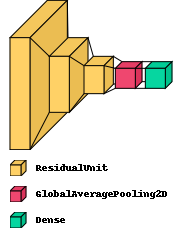

In [50]:
import visualkeras
visualkeras.layered_view(resnet_model, legend = True)

The articheture of the ResNet model is based on the base model of section 2 with three residual units having internal colvolutional layers of the sizes 32, 64 and 128 respectively. The MaxPooling layer and adjacent Batch Normalisation layer in between the residual units are removed, particularly because the MaxPooling would contribute excessive dimensionality reduction and hence information loss. Instead the stride of 2 in the internal convolutional layers is sufficient for downsampling. Also, the Batch Normalisation within the residual units in sufficiently place to ensure normalised outputs of preceding layer.
In addition, a GlobalAvgPool2D layer replaces the Flatten layer. The advantages of this is that the final Global average pooling contributes further dimensionality reduction by converting 7 x 7 feature maps of the 3rd residual unit  into a single value per the 128 channels. In contrast, Flatten would produce a single long vector from the entire feature map (7 x 7 x 128 long).  this greatly reduces parameters in the subsequewnt Dense layer, making the more more compact and efficient. Also. the spatial information is preserved to some extend by finding a global average per channel, instead of disregarding spatial relationships as Flatten does.

3. Train this new network the Sign Language dataset.

In [53]:
### training the resnet model
def resnet_training(resunit_filters,
                    initial_filters,
                    X_train,
                    X_validate,
                    y_train,
                    y_validate,
                    learning_rate,
                    early_stopping,
                    batch_size,
                    epochs,
                    verbose = 1):
  """
  Builds and fits the ResNet model.
  Arguements:
  resunit_filters - A list of residual units with internal convolutional filter layers with the number of filters per layer.
  resunit_filters - A list of residual units with internal convolutional filter layers with the number of filters per layer.
  X_train - training data
  X_validate - validation data
  y_train - training class labels
  y_validate - validation class labels
  learning_rate - the Learning rate scheduler callback
  early_stopping - the Early stopping callback
  batch_size - The number of batches of samples in training.
  epochs - The number of cycles of training.
  verbose - detaild of training.
  """
  #initiate timer
  time_start = perf_counter()
  #build model
  resnet_model = resnet_build_func(resunit_filters,initial_filters)
  # compile the model
  resnet_model.compile(loss='categorical_crossentropy', optimizer='nadam',metrics=['accuracy'])
  #fit the model and record the training and validation history
  history = resnet_model.fit(x=X_train,
                            y=y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            callbacks=[learning_rate,early_stopping],
                            validation_data=(X_validate,y_validate),
                            verbose = verbose)
  #record the history of the training process as a dictionary
  resnet_learning_curve_data = history.history
  max_index = argmax(resnet_learning_curve_data['val_accuracy'])
  max_val_acc = resnet_learning_curve_data['val_accuracy'][max_index]
  epoch_max = len(resnet_learning_curve_data['val_accuracy'])
  #conclude timer
  time_end = perf_counter()
  timer = time_end - time_start
  print(f'The maximum validation accuracy achieved is: {max_val_acc*100: 0.2f}% after {epoch_max + 1} epochs, taking {timer: 0.1f} seconds')
  return (resnet_learning_curve_data, resnet_model)

# define model parameters
resnet_training_params = dict(resunit_filters = resunit_filters,
                              initial_filters = initial_filters,
                              X_train = X_train_scaled,
                              X_validate = X_validate,
                              y_train = y_train_trans,
                              y_validate = y_validate,
                              learning_rate = learning_rate_schedule,
                              early_stopping = early_stopping,
                              batch_size = 128,
                              epochs = epoch_limit)

# build and train the cnn model
result5,trained_resnet_model = resnet_training(**resnet_training_params)

Epoch 1/30
215/215 [==============================] - 11s 22ms/step - loss: 0.4695 - accuracy: 0.8722 - val_loss: 10.0701 - val_accuracy: 0.0700 - lr: 0.0100
Epoch 2/30
215/215 [==============================] - 4s 19ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2955 - val_accuracy: 0.8968 - lr: 0.0063
Epoch 3/30
215/215 [==============================] - 4s 21ms/step - loss: 5.8818e-04 - accuracy: 1.0000 - val_loss: 0.0308 - val_accuracy: 0.9908 - lr: 0.0040
Epoch 4/30
215/215 [==============================] - 4s 20ms/step - loss: 4.1460e-04 - accuracy: 1.0000 - val_loss: 0.0298 - val_accuracy: 0.9897 - lr: 0.0025
Epoch 5/30
215/215 [==============================] - 4s 20ms/step - loss: 3.3603e-04 - accuracy: 1.0000 - val_loss: 0.0266 - val_accuracy: 0.9919 - lr: 0.0016
Epoch 6/30
215/215 [==============================] - 4s 21ms/step - loss: 2.9722e-04 - accuracy: 1.0000 - val_loss: 0.0259 - val_accuracy: 0.9914 - lr: 0.0010
Epoch 7/30
215/215 [==========================

4. Display your learning curves and final performance results.

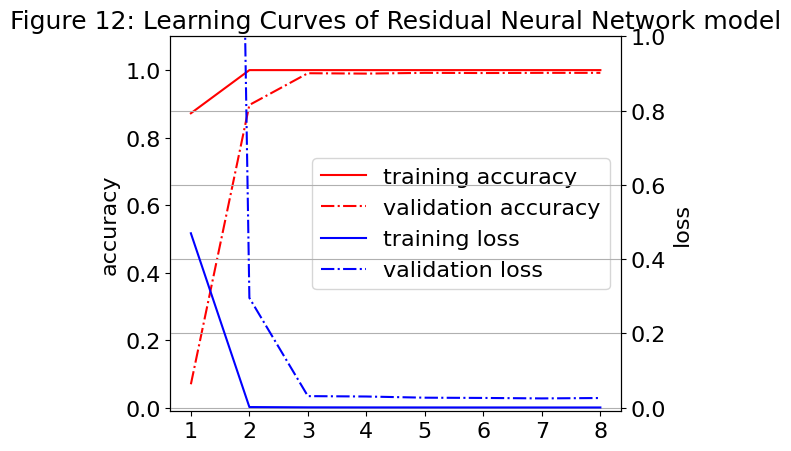

In [54]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
fig = plt.figure()
ax = fig.add_subplot(111)
lines = ['-r','-.r','-b','-.b']
labels = ['training accuracy','validation accuracy','training loss','validation loss']
epochs = [x for x in range(1,len(result5['val_accuracy'])+1)]
#define the current dictionary
data = result5.copy()
# define the number of epochs
data['epochs'] = epochs
#plot the accuracy metric
l1, = ax.plot('epochs','accuracy',lines[0],data = data,label = labels[0])
l2, = ax.plot('epochs','val_accuracy',lines[1],data = data,label = labels[1])
ax.grid(False)
ax2 = ax.twinx()
l3, = ax2.plot('epochs','loss',lines[2], data = data,label = labels[2])
l4, = ax2.plot('epochs','val_loss',lines[3], data = data,label = labels[3])
ax2.grid(True)
#label the axis
ax.set_ylabel("accuracy")
#set the range on the axis
ax.set_ylim(-0.01,1.1)
ax2.set_ylabel("loss")
ax2.set_ylim(-0.01,1)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("Figure 12: Learning Curves of Residual Neural Network model",size = 18)
#position the legend
ax.legend((l1,l2,l3,l4), labels, loc=7,prop={'size': 16})
plt.tight_layout()
#produces the graph
plt.show()

Figure 12 gives learning curve for Residual Neural Network model. It clearly shows a stable model that converges for a short number of epochs. A validation accuracy that is very high, considerably close to the training accuracy, and a validation loss that is very low and close to traning loss. The performance against the test data set is given below:

In [55]:
new_line = '\n'
resnet_scores = trained_resnet_model.evaluate(X_test_scaled,y_test_trans)
print(f'Accuracy of the model is -  {resnet_scores[1]*100: 0.2f}%{new_line}\
The Loss of the model is - {resnet_scores[0]:0.4f}{new_line}\
The total number of parameters for the model is {trained_resnet_model.count_params()}')
#model 3 - ResNet model
model_performance[2][0] = resnet_scores[0]
model_performance[2][1] = resnet_scores[1]
model_performance[2][2] = trained_resnet_model.count_params()

113/113 [==============================] - 0s 4ms/step - loss: 0.0274 - accuracy: 0.9905
Accuracy of the model is -   99.05%
The Loss of the model is - 0.0274
The total number of parameters for the model is 301880


5. Question: What do you conclude about the fitting and the results that you have obtained (i.e. is the ResNet similar, better or worse than previous networks) and what reason would give for this?

The ResNet performs very well under training and its validation accuracy and loss out performs the other models. The model also performs exceptrionally well under the test data set, with performance exceeding the other models. This is due to the ResNet architecture, particularly the skip connections of the residual units. The skip connections allow the model to learn residual values, which helps to address the issue of the vanishing gradient problem that plagues traditional Convolutional Neural Networks. The skip connection of the residual units also enable the network to be deeper, giving the potential  to learn more complex representations, and easier to optimise by mitigating the degradation problem seen in deep CNNs. This is more evident in the learning curve of figure 12, showing a very stable learning process that converges to high performing values within a short amount of epochs. The skip connections in the ResNet model can act as regularisers by preventing overfitting. In introducing additional paths for information flow and providing shortcuts for gradient updates, the ResNet generalises better and reduces overfitting to the training data.

***
# 5. Final evaluation

1. Choose the best network (from all the options you have explored above in sections 2, 3 and 4) and explain your reasons, and then evaluate the final performance results

The chosen model is th ResNet model due to its innovative architecture with residual connections, enabling training of deeper networks capturing data complexities, prevents degradation problems and facilitates the learning of more effective feature representations.

In [56]:
final_performance_results = pd.DataFrame(model_performance,
                                        columns = ["Performance loss", "Performance accuracy", "number of parameters"],
                                        index = ['base CNN','tuned CNN','ResNet'])
final_performance_results["Performance accuracy"] = final_performance_results["Performance accuracy"].map(lambda x: f'{x*100:0.2f}%')
final_performance_results["Performance loss"] = final_performance_results["Performance loss"].map(lambda x: f'{x:0.3f}')
final_performance_results["number of parameters"] = final_performance_results["number of parameters"].map(lambda x: int(x))
final_performance_results

,Performance loss,Performance accuracy,number of parameters
base CNN,0.146,95.54%,142744
tuned CNN,0.248,93.03%,48344
ResNet,0.027,99.05%,301880


The summary table of model test performance clearly shows that the ResNet model performs the best out of the three models, despite the increase in number parameters. This increase however is not an issue in training the ResNet model as its achitecture is effient and easy to optimize due to the advantages of the skip connection in the residual units. The ResNet learning curve in Figure 12 highlights stable training and convergence with less than 9 epochs, whereas the other CNN models converge for greater number of epochs. The ResNet achieves a test accuracy of 99.05% with a loss of 0.027, an improvement on the other models by a whole order of magnitude.
On the contrary, the tuned model with kernel regularisation of $10^{-5}$ and smaller layer sizes than the base model, that is, $[16,32,64]$ as opposed to $[32,64,128]$, greatly reduces the number of parameters and is more efficient than the base model, but has slightly reduced performance. The greater depth of the base model CNN captures better the complexity of the data, but at the expense of longer training duration.

2. Calculate the confusion matrix and show the matrix graphically

113/113 [==============================] - 0s 3ms/step


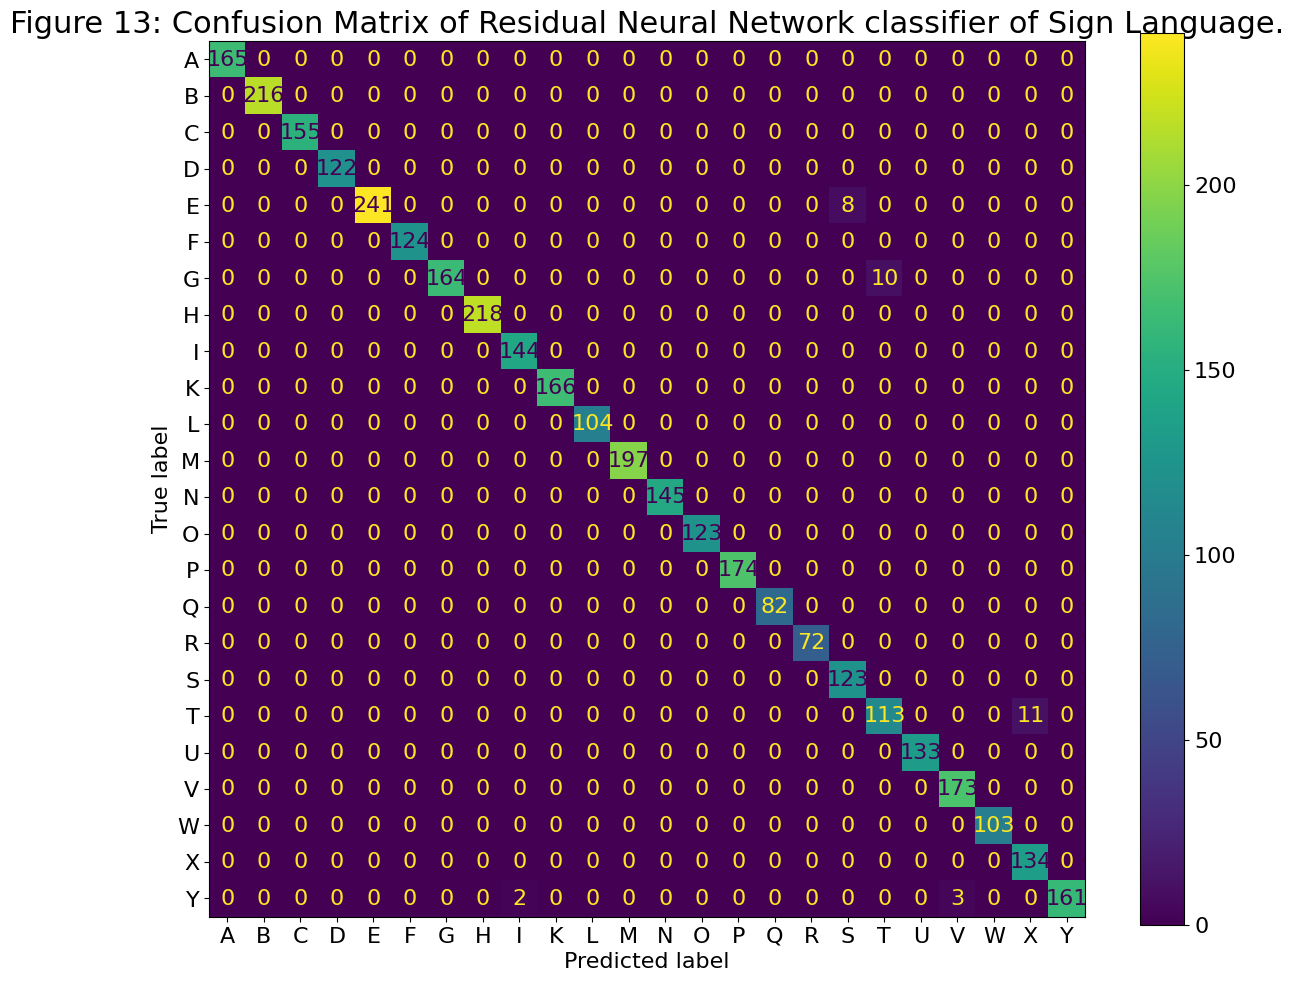

In [57]:
# predictions of classes using the test data set
resnet_prediction_probs = trained_resnet_model.predict(X_test_scaled)
#determine the class with the highest probability score as a numerical label from 0 to 24
resnet_prediction_labels = label_binarizer.inverse_transform(resnet_prediction_probs)
#determine the class with a label from 0 to 24 from binary encoded y_test data set
#y_test_labels = label_binarizer.inverse_transform(y_test)
# Evaluate the predictions by analysing the confusion matrix.
resnet_cm = confusion_matrix(y_test_labels,resnet_prediction_labels)
#Initialise the figure of the Confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
ax.grid(False)
#Set title and font size of the Confusion Matrix
plt.title("Figure 13: Confusion Matrix of Residual Neural Network classifier of Sign Language.",{'fontsize': 22})
plt.rc('font', **{'size':16})
#Display confusion matrix from the predictions on the testing data set
ConfusionMatrixDisplay.from_predictions(y_test_labels,resnet_prediction_labels,ax=ax )
fig.tight_layout()


3. Question: Which class is most often incorrectly classified? Explaining your reasoning.

The class **T** is misclassified as class **X** in 11 instances. The class **Y** is  misclassified as a **I** with 2 instances and as a **V** with 3 instances. Class **G** is misclassified as class **T** in 10 instances. Also the class **E** is misclassified as class **S** with 8 instances.

In [58]:
print(f' Proportion of misclassification of class T  as class X is : {11*100/(11+113): 0.2f}%')
print(f' Proportion of misclassification of class G  as class T is : {10*100/(10+164): 0.2f}%')
print(f' Proportion of misclassification of class E  as class S is : {8*100/(8+241): 0.2f}%')
print(f' Proportion of misclassification of class Y  as class V is : {3*100/(3+1161): 0.2f}%')

 Proportion of misclassification of class T  as class X is :  8.87%
 Proportion of misclassification of class G  as class T is :  5.75%
 Proportion of misclassification of class E  as class S is :  3.21%
 Proportion of misclassification of class Y  as class V is :  0.26%


The most common misclassification is class **T** at 8.87%, misclassified as an **X**. This could be because both images consist of the index figure pointing to the right, while all other fingures are clinched in a fist. This similarity could make it difficult for the RNN model to discern all examples. The next greatest proportion of misclassification is class **G** at 5.75%, misclassified as class **T**. This has occurred as there is little discernable difference between the images of the two signs other than the presence of a vertical thumb in the image of class **T**. There could be instances of class **T** in the data set where the thumb is less pronounced and thus the image appears considerably similar to an image of class **G**.